<a href="https://colab.research.google.com/github/LittlePandaCode/British_Airways/blob/main/BA_project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import wordcloud
import requests
import nltk
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [ ]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [ ]:
df = pd.DataFrame()
df["reviews"] = reviews
df['id']=df.index

df.head(8)

,reviews,id
0,✅ Trip Verified | We booked premium economy r...,0
1,✅ Trip Verified | We chose Rotterdam and Lond...,1
2,✅ Trip Verified | The entire booking and ticke...,2
3,Not Verified | British Airways cancelled my ...,3
4,Not Verified | I wanted to write this review s...,4
5,✅ Trip Verified | Check in fast and friendly....,5
6,✅ Trip Verified | This is the first time I ha...,6
7,✅ Trip Verified | Flew business class from Do...,7


##  **Clean and prepare data**

In [ ]:
word_to_remove='✅ Trip Verified '
word_to_remove_1='Not Verified '
characters_remove=r'[|.,()\\"$!?/:;\-\'\'£#$&]'

df['reviews']=df['reviews'].str.replace(word_to_remove,'')
df['reviews']=df['reviews'].str.replace(word_to_remove_1,'')
df['reviews']=df['reviews'].dropna()
df['reviews']=df['reviews'].str.replace(characters_remove,'',regex=True)
df['reviews']=df['reviews'].str.lower()
df['reviews']=df['reviews'].replace('[1234567890]', '', regex=True)

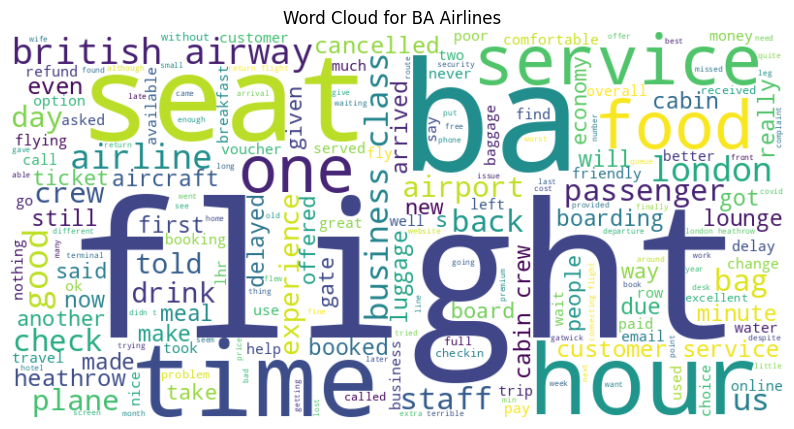

In [ ]:
# combine all the reviews lignes into one string
all_reviews=''.join(df['reviews'])
all_reviews
# creat a word cloud
wordcloud=WordCloud(random_state = 8, width=800,height=400,background_color='white' ).generate(all_reviews)
# display the word cloud

plt.figure(figsize=(10,9))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for BA Airlines  ')
plt.show()

In [ ]:
df.head()

,reviews,id
0,we booked premium economy round trip from ph...,0
1,we chose rotterdam and london city airport b...,1
2,the entire booking and ticketing experience h...,2
3,british airways cancelled my flight less th...,3
4,i wanted to write this review so i could give...,4


## **Tokenisation Technics**

In [ ]:
from nltk import ngrams
from nltk.tokenize import WordPunctTokenizer

tokens=WordPunctTokenizer().tokenize(all_reviews)
# bigrams= [w for w in ngrams(tokens, n=2)] give us couple of words
tokens[:10]

['we',
 'booked',
 'premium',
 'economy',
 'round',
 'trip',
 'from',
 'phoenix',
 'to',
 'zurich']

In [ ]:
import nltk
nltk.download('averaged_perceptron_tagger')
tagged = nltk.pos_tag(tokens)
tagged[:10]

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('we', 'PRP'),
 ('booked', 'VBD'),
 ('premium', 'JJ'),
 ('economy', 'NN'),
 ('round', 'NN'),
 ('trip', 'NN'),
 ('from', 'IN'),
 ('phoenix', 'NN'),
 ('to', 'TO'),
 ('zurich', 'VB')]

## Step 3: Reberta Pretrained model


* use a model trained of a large corpus of data
* Transformer model accounts for the words but also the context related to other words.

we went to determine the pourcentage of positive, neutral and negative words in each review



In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [ ]:
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
Model=f'cardiffnlp/twitter-roberta-base-sentiment'
tockenizer=AutoTokenizer.from_pretrained(Model)
model= AutoModelForSequenceClassification.from_pretrained(Model)


In [ ]:
# run the reberto model
def polarity_scores_Reberta(review):
   encoded_text=tockenizer(review, return_tensors='pt')
   output=model(**encoded_text)
   scores=output[0][0].detach().numpy()
   scores=softmax(scores)
   scores_dict={
    'Reberto_neg':scores[0],
    'Reberto_neu':scores[1],
    'Reberto_pos':scores[2]
     }
   return(scores_dict)


In [ ]:
reberta_result={}
for i, row in tqdm(df.iterrows(),total=len(df)):
  try:
    review=row['reviews']
    id=row['id']
    reberta_result[id]=polarity_scores_Reberta(review)
  except RuntimeError :
    print(f'broke for id {id}')

In [ ]:
Reberta=pd.DataFrame(reberta_result).T
Reberta.reset_index().rename(columns={'index':'id'})

,id,Reberto_neg,Reberto_neu,Reberto_pos
0,1,0.148073,0.398484,0.453443
1,2,0.899050,0.094194,0.006755
2,3,0.946155,0.048504,0.005342
3,4,0.010078,0.083484,0.906438
4,5,0.040289,0.157767,0.801944
...,...,...,...,...
976,995,0.002756,0.029660,0.967584
977,996,0.449281,0.402275,0.148444
978,997,0.002195,0.030440,0.967365
979,998,0.950019,0.046095,0.003886


## Analyse of sentiments distribution
 Calculate the overall distribution of sentiments to get a general idea of customers' opinions about BA airways.

In [ ]:
df_sentiment=Reberta.loc[(Reberta['Reberto_neg']>=Reberta['Reberto_neu']) | (Reberta['Reberto_pos']>=Reberta['Reberto_neu']),['Reberto_neg','Reberto_pos']]
df_sentiment.reset_index(inplace = True)
df_sentiment.head(3)

,index,Reberto_neg,Reberto_pos
0,1,0.148073,0.453443
1,2,0.899050,0.006755
2,3,0.946155,0.005342


In [ ]:
# determiner le nombre des commentaires positives et negatives
pos_sentiment=len(df_sentiment.loc[df_sentiment['Reberto_pos']> df_sentiment['Reberto_neg']])
neg_sentiment=len(df_sentiment.loc[df_sentiment['Reberto_neg']> df_sentiment['Reberto_pos']])
neutral=len(Reberta)-pos_sentiment-neg_sentiment
print(neutral,pos_sentiment,neg_sentiment)

75 296 610


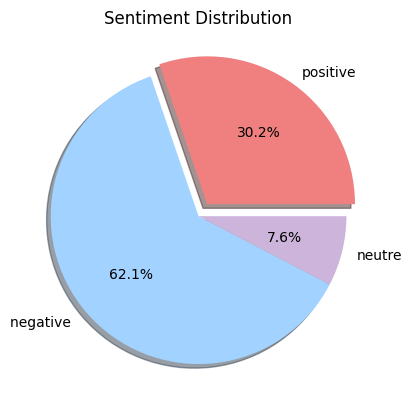

In [ ]:
 # Structure des données
 labels = 'positive', 'negative ', 'neutre'
 sizes = [297, 610,75]
 # Mise en forme du graphique
 colors = [ 'lightcoral', '#a2d2ff','#cdb4db']
 explode = (0.1, 0,0)  # juste le premier groupe
 # graphique
 plt.pie(sizes, explode=explode, labels=labels, colors=colors,
 autopct='%1.1f%%', shadow=True)
 plt.title('Sentiment Distribution')
 plt.show()

## Step 1 : VADER Sentiment Scoring
VADER: stands for (Valence Aware Dictionary and sEntiment Reasoner)

"the second methode to analyse word in each review"

We will uses NLTK's SentimentIntensityAnalyser to get the neg/neu/pos scores of the tex

 this uses a "bag words" approach:                                            

*   Stop words are removed  
*   each word is scored and combined to a total score      

words either has negative , positive or neutral score
this method doesn't include relationships between words


In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

In [ ]:
#let's take some examples
sia.polarity_scores('am happy!')

In [ ]:
sia.polarity_scores('this is the worst thing ever!')

In [ ]:
# let's applied it to our dataset
res={}
for i, row in tqdm(df.iterrows(),total=len(df)):
  reviews=row['reviews']
  myid=row['id']
  res[myid]=sia.polarity_scores(reviews)


In [ ]:
vaders=pd.DataFrame(res).T
vaders.reset_index().rename(columns={'index':'id'})


In [ ]:
nltk.download('maxent_ne_chunker')
nltk.download('words')
entities=nltk.chunk.ne_chunk(tagged)
